In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [19]:
df = pd.read_csv('../data/crypto-markets.csv')

df = df.drop(columns=['slug'])
df['date'] = pd.to_datetime(df['date'])
# min_date = df['date'].min()
# max_date = df['date'].max()
df = df.sort_values(['symbol', 'date'])

# df['log_volume'] = np.log1p(df['volume'])
df['log_market'] = np.log1p(df['market'])
df.drop(columns=['market'], inplace=True)

coin_ranges = df.groupby('symbol')['date'].agg(['min', 'max']).reset_index()
coin_ranges.head

zero_volume_ratio = df.groupby('symbol')['volume'].apply(lambda x: (x == 0).mean())
threshold = 0.5
low_liquidity_coins = zero_volume_ratio[zero_volume_ratio > threshold].index
filtered_df = df[~df['symbol'].isin(low_liquidity_coins)]

print(f"Removed {len(low_liquidity_coins)} coins with low liquidity.")

# df.replace(['null', 'NULL', 'N/A', '', 'unknown'], np.nan, inplace=True)
df.isnull().values.any()


Removed 7 coins with low liquidity.


False

In [20]:
# Extract time-series summary features per df numeric feature per coin
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

def extract_coin_features(group):
    features = {}
    for col in numeric_cols:
        series = group[col]
        features[f'{col}_mean'] = series.mean()
        features[f'{col}_std'] = series.std()
        features[f'{col}_min'] = series.min()
        features[f'{col}_max'] = series.max()
        features[f'{col}_trend'] = np.polyfit(range(len(series)), series, deg=1)[0] if len(series) > 1 else 0
    return pd.Series(features)

feature_df = df.groupby('symbol').apply(extract_coin_features).dropna()
feature_df

/var/folders/0n/kwcts2ks32n5v8884446s1j40000gn/T/ipykernel_61943/3523200896.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_df = df.groupby('symbol').apply(extract_coin_features).dropna()


,ranknow_mean,ranknow_std,ranknow_min,ranknow_max,ranknow_trend,open_mean,open_std,open_min,open_max,open_trend,...,spread_mean,spread_std,spread_min,spread_max,spread_trend,log_market_mean,log_market_std,log_market_min,log_market_max,log_market_trend
symbol,,,,,,,,,,,,,,,,,,,,,
$$$,1634.0,0.0,1634.0,1634.0,1.017259e-15,0.000976,0.001649,5.000000e-06,0.017379,2.548267e-06,...,0.000036,0.000601,0.00,0.01,8.227026e-08,8.815137,2.658548,0.000000,13.587910,0.007016
$PAC,419.0,0.0,419.0,419.0,-8.666773e-16,0.001041,0.002181,2.500000e-09,0.016133,3.908197e-06,...,0.000000,0.000000,0.00,0.00,0.000000e+00,5.017080,7.705440,0.000000,20.388653,0.018320
0XBTC,706.0,0.0,706.0,706.0,-2.062632e-15,0.758279,0.583010,2.617410e-01,4.230000,-7.844581e-03,...,0.181117,0.251914,0.03,2.14,-2.483774e-03,13.680182,3.181086,0.000000,15.653049,0.017491
1337,1251.0,0.0,1251.0,1251.0,1.155274e-15,0.000075,0.000114,6.500000e-07,0.001085,1.387695e-07,...,0.000000,0.000000,0.00,0.00,0.000000e+00,11.992352,2.967336,0.000000,17.096907,0.007527
1ST,498.0,0.0,498.0,498.0,4.375284e-16,0.360271,0.396487,3.207100e-02,2.730000,-1.264999e-04,...,0.067011,0.126574,0.00,1.84,-3.032604e-05,14.683922,5.779979,0.000000,19.276841,0.013363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZT,2065.0,0.0,2065.0,2065.0,-6.612451e-14,0.100920,0.014361,7.351200e-02,0.127372,-1.117907e-03,...,0.010263,0.004925,0.00,0.02,-1.422475e-05,0.000000,0.000000,0.000000,0.000000,0.000000
ZUR,1596.0,0.0,1596.0,1596.0,1.185062e-16,0.001341,0.002008,1.200000e-05,0.020219,2.682945e-06,...,0.000188,0.001741,0.00,0.03,2.921763e-08,10.436853,1.844675,6.684612,14.380406,0.005899
ZXC,1034.0,0.0,1034.0,1034.0,-4.955544e-15,0.011653,0.010145,1.905000e-03,0.039791,-2.092171e-04,...,0.000638,0.002453,0.00,0.01,-2.084850e-05,11.318317,5.038921,0.000000,14.722284,0.069892


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppre

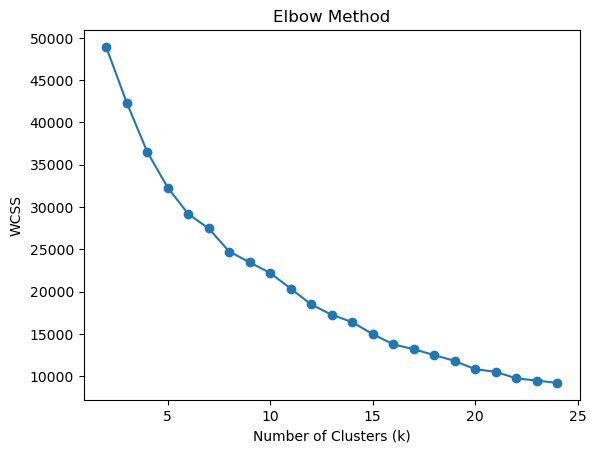

In [21]:
scaler = StandardScaler()
scaled_feature_df = scaler.fit_transform(feature_df)

wcss = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_feature_df)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS (within-cluster sum of squares)

plt.plot(range(2, 25), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [22]:
from sklearn.metrics import silhouette_score

for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_feature_df)
    score = silhouette_score(scaled_feature_df, labels)
    print(f"k={k}, silhouette score={score:.3f}")

pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_feature_df)


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=2, silhouette score=0.967
k=3, silhouette score=0.264


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=4, silhouette score=0.266
k=5, silhouette score=0.272


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=6, silhouette score=0.248
k=7, silhouette score=0.258
k=8, silhouette score=0.259


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=9, silhouette score=0.246


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=10, silhouette score=0.257


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=11, silhouette score=0.274


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=12, silhouette score=0.280
k=13, silhouette score=0.262


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=14, silhouette score=0.278


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=15, silhouette score=0.273


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=16, silhouette score=0.285


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=17, silhouette score=0.281


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=18, silhouette score=0.271


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=19, silhouette score=0.238


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=20, silhouette score=0.251


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=21, silhouette score=0.243


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=22, silhouette score=0.257


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=23, silhouette score=0.259


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k=24, silhouette score=0.234


/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


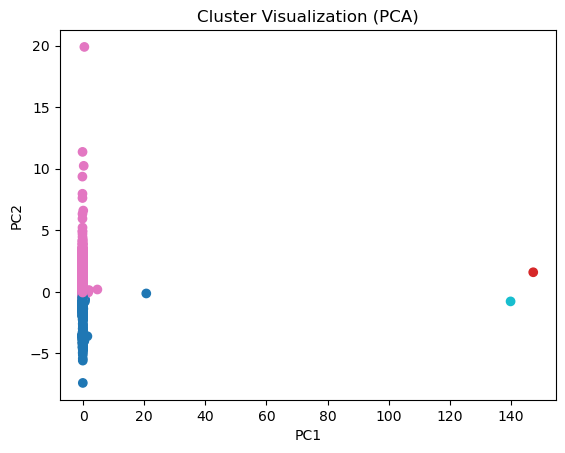

In [25]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(scaled_feature_df)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10')
plt.title("Cluster Visualization (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [27]:
clustered_df = pd.DataFrame({
    'symbol': feature_df.index, 
    'cluster': clusters
})

for cluster_id in sorted(clustered_df['cluster'].unique()):
    group = clustered_df[clustered_df['cluster'] == cluster_id]
    symbols = group['symbol'].tolist()
    print(f"\n🟢 Cluster {cluster_id} ({len(symbols)} coins):")
    print(", ".join(symbols))


🟢 Cluster 0 (813 coins):
$$$, 1337, 300, 42, 611, 8BIT, ABBC, ABC, ABDT, AC, ACC, ACDC, ACED, ACES, ACOIN, ACP, ACRE, ACTP, ADCN, ADK, ADL, ADZ, AEC, AEG, AGLT, AI, AIB, ALC, ALL, ALT, ALTX, AMMO, AMS, ANC, ANI, ANON, APC, APOT, ARB, ARCO, AREPA, ARGUS, ARI, ARION, ASA, ASAFE2, AT, ATC, ATD, ATH, ATOM, ATP, ATS, AV, AVH, AXIOM, AZART, B2X, B@, BAAS, BANK, BBS, BC, BCARD, BCDN, BCDT, BCF, BCV, BCX, BDL, BEAT, BENJI, BENZ, BERN, BET, BFF, BGG, BIFI, BIGUP, BIRDS, BIT, BITBTC, BITCF, BITEUR, BITF, BITGOLD, BITS, BITSILVER, BKBT, BLACK, BLAST, BLAZR, BLC, BLN, BLU, BNK, BNN, BOAT, BOC, BOLI, BOST, BQT, BRAT, BRIA, BRIT, BRO, BSC, BSM, BSN, BSTY, BSX, BTA, BTAD, BTB, BTBC, BTCM, BTCN, BTCONE, BTCRED, BTCS, BTDX, BTNT, BTPL, BTQ, BTRN, BU, BUB, BUBO, BUMBA, BUN, BUT, BUZZ, BWS, BZL, BZX, C2, C2C, C2P, C8, CAB, CANDY, CAR, CARAT, CARBON, CARE, CASH, CAZ, CBX, CCC, CCO, CCT, CDC, CDN, CDX, CEDEX, CEFS, CEL, CEN, CET, CF, CFC, CGEN, CHE, CHEESE, CHESS, CHEX, CHIPS, CIF, CIT, CIV, CJ, CJS, CJT,